In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer

import seaborn as sns
sns.set(rc={'figure.figsize':(6,6)})
import warnings
warnings.simplefilter("ignore")

%matplotlib inline

# Cleaning the Two Year Data

In [5]:
df_com = pd.read_csv("/content/compas-scores-two-years.csv")

In [6]:
#drop irrelevant columns
drop_columns = ['compas_screening_date', 'juv_fel_count',
                'juv_misd_count','c_case_number','vr_charge_degree',
                'vr_offense_date','vr_charge_desc','c_arrest_date',
                'r_case_number', 'vr_case_number','start',
                'juv_other_count','days_b_screening_arrest','c_days_from_compas',
                'first','last','name','dob','c_jail_in','c_jail_out','c_offense_date',
                'c_charge_degree','c_charge_desc','r_charge_degree','r_days_from_arrest',
                'r_offense_date','r_charge_desc','r_jail_in','r_jail_out','violent_recid',
                'score_text','screening_date','v_score_text','v_screening_date','in_custody',
                'out_custody','id','age_cat','is_recid','is_violent_recid','decile_score.1',
                'priors_count.1','end','event','type_of_assessment','v_type_of_assessment','race']
df_com = df_com.drop(drop_columns,axis=1)

In [7]:
df_com.head()

,sex,age,decile_score,priors_count,v_decile_score,two_year_recid
0,Male,69,1,0,1,0
1,Male,34,3,0,1,1
2,Male,24,4,4,3,1
3,Male,23,8,1,6,0
4,Male,43,1,2,1,0


In [8]:
#converting dataset into numerical and categorical to do futher analysis
num_data = df_com.select_dtypes(np.number)
cat_data = df_com.select_dtypes([object, "category"])

In [9]:
#normalizing the dataset
num_data_norm = MinMaxScaler().fit_transform(num_data)

num_data_norm = pd.DataFrame(              #this pops it back in data frame format
                    num_data_norm,
                    columns=num_data.columns)

num_data_norm.head()

,age,decile_score,priors_count,v_decile_score,two_year_recid
0,0.653846,0.000000,0.000000,0.000000,0.0
1,0.205128,0.222222,0.000000,0.000000,1.0
2,0.076923,0.333333,0.105263,0.222222,1.0
3,0.064103,0.777778,0.026316,0.555556,0.0
4,0.320513,0.000000,0.052632,0.000000,0.0


In [10]:
#Encoding  categorical data
cat_data_en = pd.get_dummies(
                                    cat_data,
                                    dtype="int64",
                                    drop_first = True
).reset_index()

In [11]:
#Merging categorical and numerical columns
df_pre = pd.concat([num_data_norm, cat_data_en], axis=1)
df_pre.head()

,age,decile_score,priors_count,v_decile_score,two_year_recid,index,sex_Male
0,0.653846,0.000000,0.000000,0.000000,0.0,0,1
1,0.205128,0.222222,0.000000,0.000000,1.0,1,1
2,0.076923,0.333333,0.105263,0.222222,1.0,2,1
3,0.064103,0.777778,0.026316,0.555556,0.0,3,1
4,0.320513,0.000000,0.052632,0.000000,0.0,4,1


# K-means cluster

In [12]:

def evaluate_k_kmeans(k):
    print(f"Kmeans with k={k}")
    es_kmeans = KMeans(random_state=42, n_clusters=k)
    es_kmeans.fit(df_pre)
    return es_kmeans.inertia_

In [13]:
range_k = [2, 3, 4, 5, 8, 10, 15, 20, 25, 30]
results_k_clus = {}
for k in range_k:
    results_k_clus[k] = evaluate_k_kmeans(k)

Kmeans with k=2
Kmeans with k=3
Kmeans with k=4
Kmeans with k=5
Kmeans with k=8
Kmeans with k=10
Kmeans with k=15
Kmeans with k=20
Kmeans with k=25
Kmeans with k=30


In [14]:
results_k_clus

{2: 7821484603.296209,
 3: 3476419922.350761,
 4: 1955384431.526747,
 5: 1251523815.0078773,
 8: 489170520.30890906,
 10: 312945016.8681222,
 15: 139312234.43867865,
 20: 78445696.12321295,
 25: 50244800.58221398,
 30: 35007556.33380324}

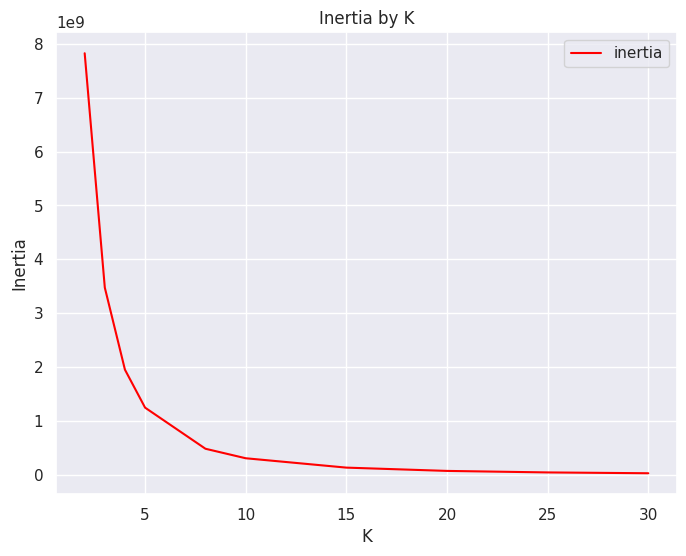

In [17]:
# identifying the inflection point
fig, ax = plt.subplots(figsize=(8, 6))
sns.lineplot(
    x=list(results_k_clus.keys()),
    y=list(results_k_clus.values()),
    label="inertia",
    color="red",
    ax=ax
)
ax.set_xlabel("K")
ax.set_ylabel("Inertia")
ax.set_title("Inertia by K")
ax.legend()
plt.show()


The inflection point is about 8, so the number of clusters may be 8.

### creating,training,evaluating model

In [18]:
#kmeans model
es_kmeans = KMeans(random_state=42, n_clusters=8)

In [19]:
es_kmeans.fit(df_pre)

KMeans(random_state=42)

In [20]:
#creating clusters
es_kmeans.predict(df_pre)

array([6, 6, 6, ..., 7, 7, 7], dtype=int32)

In [21]:

df_pre["cluster_id"] = es_kmeans.labels_
df_pre.head()

,age,decile_score,priors_count,v_decile_score,two_year_recid,index,sex_Male,cluster_id
0,0.653846,0.000000,0.000000,0.000000,0.0,0,1,6
1,0.205128,0.222222,0.000000,0.000000,1.0,1,1,6
2,0.076923,0.333333,0.105263,0.222222,1.0,2,1,6
3,0.064103,0.777778,0.026316,0.555556,0.0,3,1,6
4,0.320513,0.000000,0.052632,0.000000,0.0,4,1,6


### Analysis of Clusters

In [22]:
#look at the amount of each cluster to make sure the clusters are balanced
df_pre.cluster_id.value_counts()

0    917
4    914
5    911
2    906
6    901
3    901
1    886
7    878
Name: cluster_id, dtype: int64

In [23]:
def kmeans_cluster(df, n_clusters=2):
    model_k = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = model_k.fit_predict(df)
    cluster_res = df.copy()
    cluster_res['Cluster'] = clusters
    return cluster_res

def graph_summary_cluster(results):
    cluster_s = results.groupby(['Cluster']).size().reset_index()
    cluster_s.columns = ['Cluster', 'Count']
    cluster_means = results.groupby(['Cluster'], as_index=False).mean()
    cluster_sum = pd.merge(cluster_s, cluster_means, on='Cluster')
    cluster_sum = cluster_sum.drop(["Count", "index"], axis=1).set_index("Cluster")
    return cluster_sum[sorted(cluster_sum.columns)]

In [25]:
clus_results = kmeans_cluster(df_pre, 8)
clus_sum = graph_summary_cluster(clus_results);

It generates a summary that provides findings into the distribution of numerical variables across clusters, highlighting clusters with higher values. For categorical variables, the summary includes the percentage of each cluster associated with distinct values within each categorical column.

In [26]:
clus_sum

,age,cluster_id,decile_score,priors_count,sex_Male,two_year_recid,v_decile_score
Cluster,,,,,,,
0,0.214030,0.004367,0.407448,0.095323,0.814410,0.474891,0.314653
1,0.208665,1.004505,0.397397,0.092757,0.798423,0.433559,0.306431
2,0.219788,2.000000,0.377238,0.088271,0.802428,0.415011,0.285136
3,0.214519,3.004440,0.392650,0.088761,0.817980,0.465039,0.301147
4,0.222807,4.000000,0.381283,0.090823,0.841183,0.441402,0.292808
5,0.218779,4.989023,0.380900,0.089433,0.774973,0.455543,0.283083
6,0.212954,6.000000,0.396966,0.093960,0.810211,0.446171,0.311012
7,0.213086,7.000000,0.385725,0.091716,0.792711,0.473804,0.298659


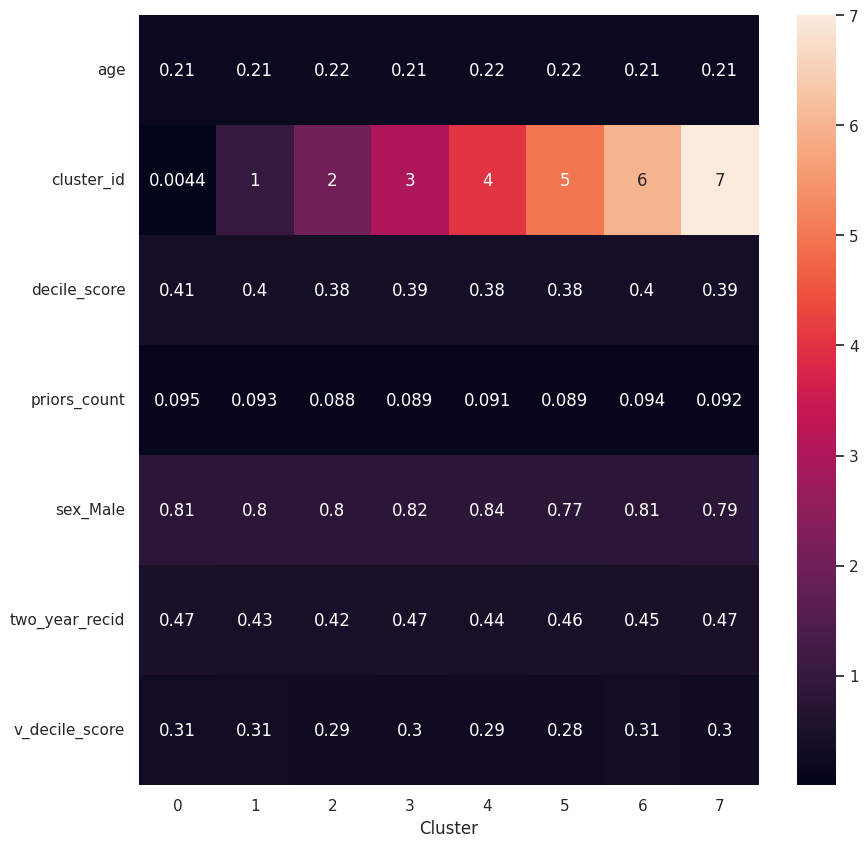

In [27]:
#summary heatmap
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(clus_sum.transpose(), annot=True);

 The data does not show different natural clusters, as all identified clusters appear to be fairly  similar in nature.